# Telegram Group Chat analysis

I've often felt I was the most talkative among my closest friends. Since I'm a scientist, I decided to put this to the test using a few Data Science techniques. The results I found were pretty Interesting

In [1]:
# taking care of dependencies I'll be using
import json
import pandas as pd
import unidecode
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import plotly.express as px
from datetime import datetime
import numpy as np
import matplotlib
import re
import seaborn as sns
from itertools import groupby
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

###### Telegram allows you to download your personal chat history in json format. I won't be sharing mine for obvious reasons, but this notebook should be easily applicable to your personal / group chat data.

In [2]:
#loading up the result.json data file just as it was provided by Telegram
data_file= 'data/terapia_de_grupo/result.json'

with open(data_file) as json_file:
    data = json.load(json_file)

## Let's do some exploratory analysis for this data...

In [3]:
data.keys()

dict_keys(['name', 'type', 'id', 'messages'])

In [4]:
data['type']

'private_group'

In [5]:
data['name']

'Terapia de grupo'

In [6]:
# now, let's see how many messages we've got, then...
len(data['messages'])

22732

###### For obvious reasons I've obfuscated `from` and `from_id`

In [7]:
# then let's see what a message looks like
data['messages'][:3]


[{'id': 9369,
  'type': 'service',
  'date': '2018-02-24T10:44:08',
  'actor': 'Alice',
  'actor_id': 1,
  'action': 'create_group',
  'title': 'Terapia de grupo',
  'members': ['Alice', 'Bob', 'Trudy'],
  'text': ''},
 {'id': 9370,
  'type': 'message',
  'date': '2018-02-24T10:44:15',
  'from': 'Alice',
  'from_id': 1,
  'file': 'stickers/sticker.webp',
  'thumbnail': 'stickers/sticker.webp_thumb.jpg',
  'media_type': 'sticker',
  'sticker_emoji': '💝',
  'width': 512,
  'height': 512,
  'text': ''},
 {'id': 9371,
  'type': 'message',
  'date': '2018-02-24T10:44:25',
  'from': 'Trudy',
  'from_id': 3,
  'text': 'Jajajaja'}]

#### At a glance this seems to be a pretty simple structure:

* Some messages might have an `action`, like that first element that identifies the `create_group` action
* Messages have an `actor` and it's associated `actor_id`
* There's an `id` that's correlative to my personal messages (yeah, I've checked: I've got 9000 accumulated messages previous to the creation of this group)
* We are interested in the messages that have `type` equal to `message`, and within those we are interested in the `text` field
* We might also consider those which have `media_type` since they might provide insight on the kind of emotes my friends use
* There might be some other message types, like `thumbnail` and `link`, so we'll need some further exploration

#### Moving on...

In [8]:
# loading `messages` to a DataFrame
df= pd.DataFrame(data['messages'])
df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
6566,21926,message,2020-03-31T17:29:36,NaN,NaN,NaN,NaN,NaN,Hasta 2gr por día podés tomar,Trudy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19679,35599,message,2020-06-27T21:06:34,NaN,NaN,NaN,NaN,NaN,mira las corrientes de viento,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6552,21912,message,2020-03-31T17:26:36,NaN,NaN,NaN,NaN,NaN,"Sí, la tengo partida hace bastante",Trudy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20223,36145,message,2020-06-30T14:46:06,NaN,NaN,NaN,NaN,NaN,"es al pedo recuperar el stage 2 a este punto, ...",Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2822,17644,message,2020-03-05T16:20:07,NaN,NaN,NaN,NaN,NaN,Cuando termine te cuento,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### But upon further analysis, we can see the message structure is not that trivial

In [9]:
df.keys()

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'members',
       'text', 'from', 'from_id', 'file', 'thumbnail', 'media_type',
       'sticker_emoji', 'width', 'height', 'mime_type', 'duration_seconds',
       'via_bot', 'photo', 'reply_to_message_id', 'forwarded_from',
       'message_id', 'edited'],
      dtype='object')

##### Apparently there are only two types of message
* `service`
* `message`

In [10]:
df['type'].unique()

array(['service', 'message'], dtype=object)

##### In case you are curious about those tagged `service` 

In [11]:
df.loc[df['type']=='service']

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
0,9369,service,2018-02-24T10:44:08,Alice,1.0,create_group,Terapia de grupo,"[Alice, Bob, Trudy]",,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,9425,service,2018-02-24T23:00:55,Bob,2.0,edit_group_photo,NaN,NaN,,NaN,...,640.0,640.0,NaN,NaN,NaN,photos/photo_3@24-02-2018_23-00-55.jpg,NaN,NaN,NaN,NaN
141,12248,service,2019-05-24T20:49:16,Bob,2.0,invite_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,15719,service,2020-02-21T09:16:57,Bob,2.0,pin_message,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15717.0,NaN
1300,15754,service,2020-02-21T09:37:53,Bob,2.0,remove_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307,15761,service,2020-02-21T10:19:56,Alice,1.0,invite_members,NaN,[Eve],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,17269,service,2020-03-03T23:27:49,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17290,service,2020-03-03T23:30:05,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14741,30299,service,2020-05-29T00:54:00,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14742,30300,service,2020-05-29T00:55:06,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The only two actors who have run `service` actions were Alice and Bob

In [12]:
df.loc[df['type']=='service']['actor'].unique()

array(['Alice', 'Bob'], dtype=object)

#### For now I'm only interested in the proper messages (not the actions)... let's see if we can get some insights

In [13]:
msg_df= df.loc[df['type']=='message']
msg_df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
10217,25625,message,2020-04-27T19:47:43,NaN,NaN,NaN,NaN,NaN,ahi te confirmo si la cierran bien o que,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7244,22629,message,2020-04-03T20:17:46,NaN,NaN,NaN,NaN,NaN,oh yeah,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11070,26506,message,2020-05-03T20:17:01,NaN,NaN,NaN,NaN,NaN,solo si sos de géminis ¿?,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3368,18234,message,2020-03-11T18:43:31,NaN,NaN,NaN,NaN,NaN,"no a todos pero se les complica mal, si",Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9531,24935,message,2020-04-22T19:28:27,NaN,NaN,NaN,NaN,NaN,dale... tengo que ver que armo,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Seems the DataFrame is pretty sparse... counting should make things easier. We've got over 22k `text` messages. That is A LOT! We'll have to come back to further explore this

In [14]:
message_count=msg_df.count()
message_count=message_count[message_count != 0] # filter out zero values
message_count['text']

22722

### For now, we'll be taking a closer look at the non-text-based message count

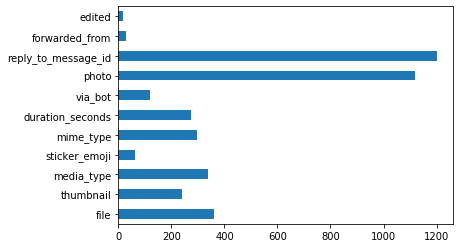

In [15]:
#dropping `text` messages and other columns that don't show interesting information
message_count_plot= message_count.drop(labels=['id','type','text','from','from_id','date','height','width'])
message_count_plot.plot.barh();

#### Some insights:
* We don't edit many of our messages after being sent
* We don't ussually forward messages
* We reply a lot of messages!
* We share a lot of images!
* We have a couple of bots
* The total amount of time in audio messages is relatively short
* We don't usually send a single emoji as a message
* We've shared over 300 files

##### Let's take a closer look at some of those insights...

In [16]:
reply_df= msg_df[['date','reply_to_message_id','from']].dropna()
reply_df

,date,reply_to_message_id,from
105,2019-05-05T16:17:09,11939.0,Alice
138,2019-05-20T17:03:29,12019.0,Alice
143,2019-05-24T20:49:20,12249.0,bot
148,2019-05-24T20:50:54,12254.0,bot
150,2019-05-24T23:09:11,12257.0,bot
...,...,...,...
22568,2020-07-10T19:28:00,38597.0,Bob
22601,2020-07-10T19:45:43,38660.0,Alice
22618,2020-07-10T19:48:21,38678.0,Alice
22682,2020-07-11T11:23:58,38732.0,Trudy


In [17]:
#some pandas-fu to create a df with the indexed dates for the replies
reply_df= pd.merge(reply_df.rename(columns={'reply_to_message_id': 'id'}),
        df[['reply_to_message_id','id','date']],
        on='id').rename(columns={'date_x': 'reply','date_y':'orig_msg'})[['reply','from','orig_msg']]
reply_df['delta']=pd.to_datetime(reply_df['reply']) - pd.to_datetime(reply_df['orig_msg']) #calculating the time delta
reply_df

,reply,from,orig_msg,delta
0,2019-05-05T16:17:09,Alice,2019-05-05T16:15:49,00:01:20
1,2019-05-20T17:03:29,Alice,2019-05-20T14:33:27,02:30:02
2,2019-05-24T20:49:20,bot,2019-05-24T20:49:20,00:00:00
3,2019-05-24T20:50:54,bot,2019-05-24T20:50:53,00:00:01
4,2019-05-24T23:09:11,bot,2019-05-24T23:09:10,00:00:01
...,...,...,...,...
1198,2020-07-10T19:28:00,Bob,2020-07-10T19:24:46,00:03:14
1199,2020-07-10T19:45:43,Alice,2020-07-10T19:45:33,00:00:10
1200,2020-07-10T19:48:21,Alice,2020-07-10T19:48:02,00:00:19
1201,2020-07-11T11:23:58,Trudy,2020-07-11T10:47:56,00:36:02


#### Now, let's plot each participant's delta time for replying.

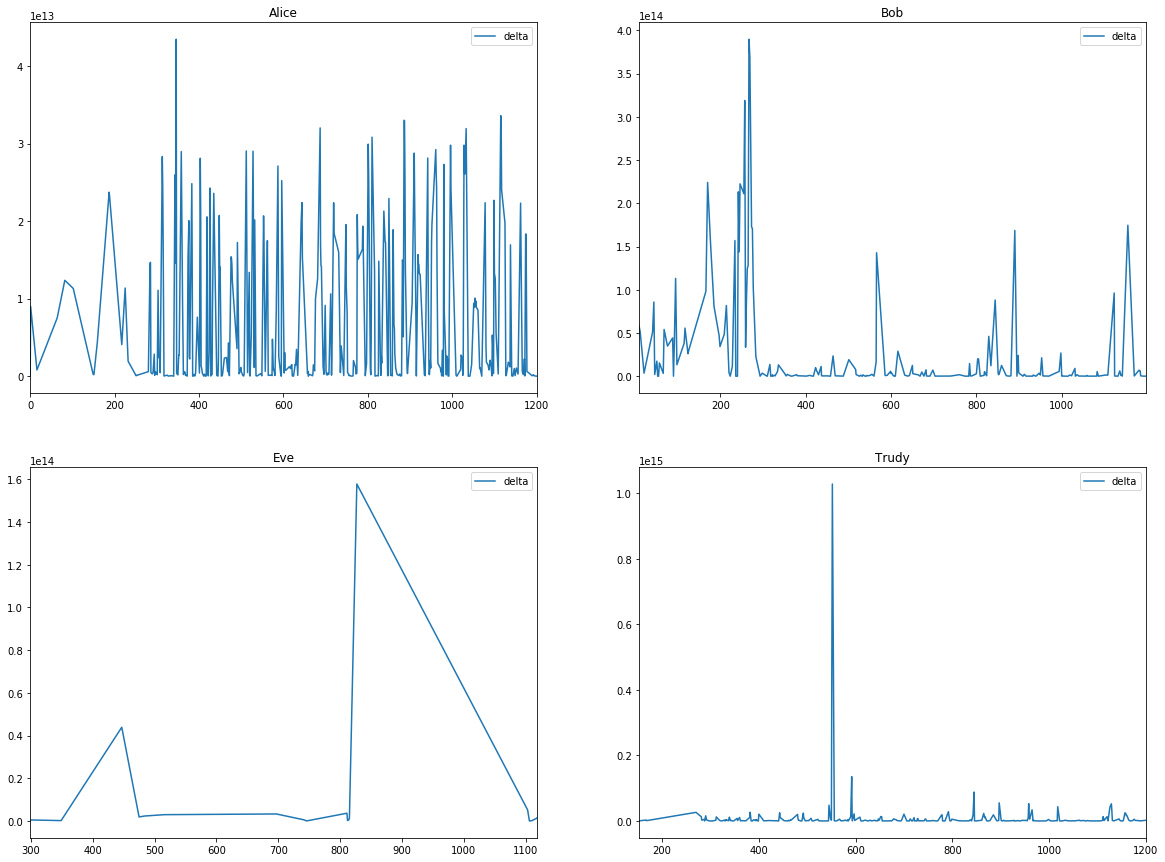

In [18]:
# might need this conversion
#reply_df['delta'] = pd.to_numeric(reply_df['delta'], errors='coerce')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
reply_df.loc[reply_df['from']=='Alice'].plot(ax=axes[0,0],
        y='delta',title='Alice'); axes[0,0].set_title('Alice')
reply_df.loc[reply_df['from']=='Bob'].plot(ax=axes[0,1],
        y='delta',title='Bob'); axes[0,1].set_title('Bob')
reply_df.loc[reply_df['from']=='Eve'].plot(ax=axes[1,0],
        y='delta',title='Eve'); axes[1,0].set_title('Eve')
reply_df.loc[reply_df['from']=='Trudy'].plot(ax=axes[1,1],
        y='delta',title='Trudy'); axes[1,1].set_title('Trudy')
plt.show();

##### Apparently:
* `Alice` replies a lot, but takes several minutes to do so
* `Bob` has some seasonality, meaning every now and then he'll take his time
* `Trudy` doesn't take much time to reply, for the most part
* `Eve` doesn't reply much

###### I forgot about the bot, but I don't expect much, since it's supposed to respond immediately

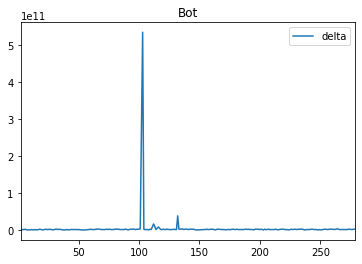

In [19]:
reply_df.loc[reply_df['from']=='bot'].plot(y='delta',title='Bot');

###### Woah! Another unexpected insight: at some point the bot had an issue and `delta` went up

## Let's move on to the next feature... Images!

##### Apparently, Telegram embeds the date on the file-name... kind of redundant if you ask me (?)

In [20]:
images_df= msg_df[['date','photo','from']].dropna()
images_df.sample(5)

,date,photo,from
3423,2020-03-12T14:45:13,photos/photo_163@12-03-2020_14-45-13.jpg,Bob
5569,2020-03-25T12:59:05,photos/photo_280@25-03-2020_12-59-05.jpg,Trudy
14094,2020-05-26T01:01:37,photos/photo_709@26-05-2020_01-01-37.jpg,Bob
5013,2020-03-22T17:04:41,photos/photo_254@22-03-2020_17-04-41.jpg,Bob
21209,2020-07-05T17:59:24,photos/photo_1041@05-07-2020_17-59-24.jpg,Bob


#### Counting the images sent by group member and...Well, well, well! It would seem like Bob is a pretty visual guy... 

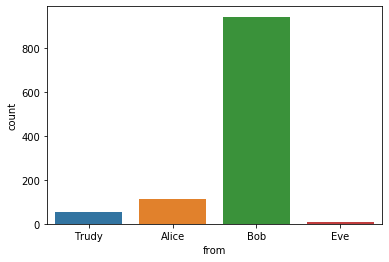

In [21]:
sns.countplot(x='from', data=images_df);

#### Let's see the actual distribution of images sent by Bob over time

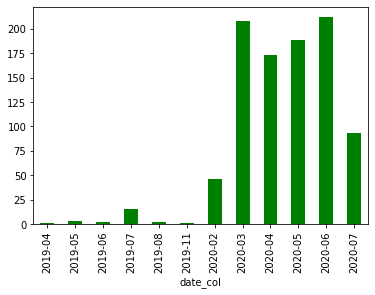

In [22]:
bobs_images_sent= images_df.loc[images_df['from']=='Bob']
bobs_images_sent['date_col'] = pd.to_datetime(bobs_images_sent['date'], utc=True)
bobs_images_sent.reset_index().set_index('date_col')
bobs_images_sent.set_index('date_col')
bobs_images_sent= bobs_images_sent['date_col'].groupby(bobs_images_sent.date_col.dt.to_period("M")).agg('count')
bobs_images_sent.plot.bar(color='g');

###### looks like Bob alternates between months whith little to no activity and others when he sends over 175 pictures per month. There might be a tendency or some seasonality but we'll have to gather more data and come back to review this graph in the future

## What about files? We've shared over 350 files over the past two years, that sounds like a lot

In [23]:
file_df= df[['date','file','from']].dropna()
file_df

,date,file,from
1,2018-02-24T10:44:15,stickers/sticker.webp,Alice
4,2018-02-24T10:44:57,stickers/sticker (1).webp,Alice
6,2018-02-24T10:46:19,video_files/animation.gif.mp4,Alice
8,2018-02-24T10:47:14,video_files/giphy.mp4,Alice
15,2018-02-24T10:49:02,video_files/giphy (1).mp4,Trudy
...,...,...,...
22288,2020-07-10T09:18:22,stickers/sticker (46).webp,Alice
22315,2020-07-10T12:29:20,video_files/mp4 (28).mp4,Bob
22316,2020-07-10T12:31:15,video_files/animation (26).gif.mp4,Alice
22671,2020-07-11T10:48:13,video_files/mp4 (29).mp4,Bob


#### Oh... now I get it! At a glance, most of the files are gif and animations... that makes sense, right?
##### Let's explore this a bit further

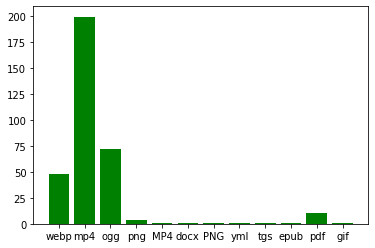

In [24]:
files_sent=file_df['file'].unique()
file_types=defaultdict(int)
for f in files_sent:
    file_types[f.split('.')[-1]]+=1

plt.bar(list(file_types.keys()),file_types.values(), color='g')
plt.show()

##### That was unexpected... there are a lot of audio files `.ogg` that I was not considering.

#### Still... The majority of the files shared were animations and audio files, let's see who's been the most active sharing files

In [25]:
# create a column with the file extension so we can filter out who sends more of each type of files
tmp2_file_df=file_df[['file','from']]
tmp2_file_df= tmp2_file_df.file.str.split('.',expand=True)
tmp2_file_df['extension']=tmp2_file_df[2].fillna(tmp2_file_df[1])
ext_df= file_df[['date','from','file']].join(tmp2_file_df['extension'])
#ext_df

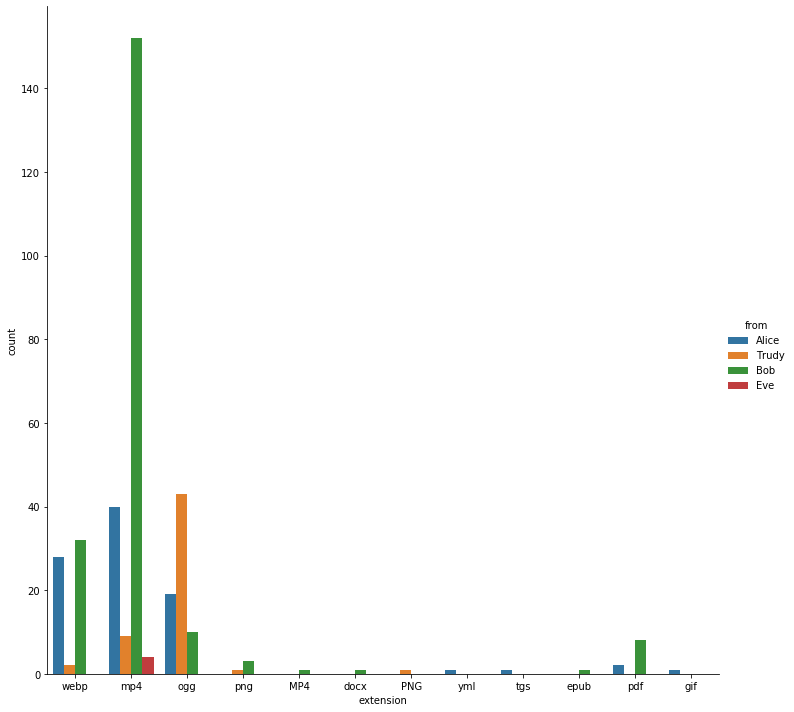

In [26]:
#plotting the distribution of files sent by each group member
g = sns.catplot(x="extension", hue="from",
                data=ext_df, kind="count",
                height=10);

###### Once again, Bob proves he is the most visual member of the group by sending too many animations. One interesting find is that Trudy appears to be the most vocal member of the group, sending the most `.ogg` audio messages!

## Moving on to Emojis!

###### In Telegram, when you send a single emoji as a message or reply, it is displayed bigger and sometimes even animated. Let's analyze those solo-emoji messages. There's not much information to work with, but let's analyze it's distribution

In [27]:
solo_emoji_df= msg_df[['sticker_emoji','from']].dropna()
solo_emoji_df['sticker_emoji'].count()

62

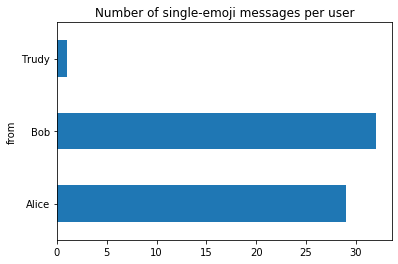

In [28]:
solo_emoji_df.groupby('from')['sticker_emoji'].count().plot.barh()
plt.title('Number of single-emoji messages per user');

In [29]:
# setting up a few pd.Series to count each member's single-emoji messages
solo_emoji_df=msg_df[['sticker_emoji','from']].dropna()
#alice
alice_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Alice']
alice_solo_emoji_count= alice_solo_emoji.groupby('sticker_emoji')['from'].count()
#bob
bob_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Bob']
bob_solo_emoji_count= bob_solo_emoji.groupby('sticker_emoji')['from'].count()
#trudy
trudy_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Trudy']
trudy_solo_emoji_count= trudy_solo_emoji.groupby('sticker_emoji')['from'].count()
#eve
eve_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Eve']
eve_solo_emoji_count= eve_solo_emoji.groupby('sticker_emoji')['from'].count()

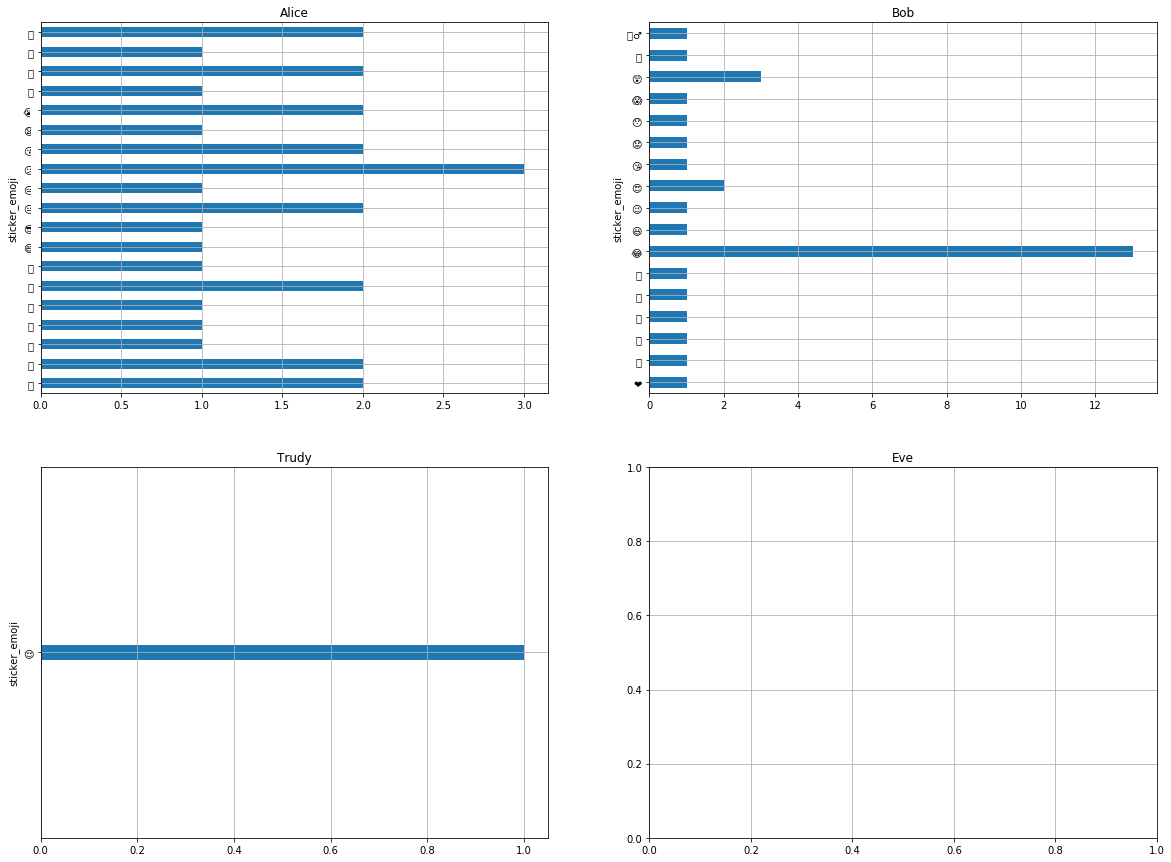

In [30]:
# plot 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
alice_solo_emoji_count.plot.barh(ax=axes[0,0],
        y='delta',title='Alice'); axes[0,0].set_title('Alice')
bob_solo_emoji_count.plot.barh(ax=axes[0,1],
        y='delta',title='Bob'); axes[0,1].set_title('Bob')
trudy_solo_emoji_count.plot.barh(ax=axes[1,0],
        y='delta',title='Trudy',width=0.02); axes[1,0].set_title('Trudy')
#eve_solo_emoji_count.plot.barh(ax=axes[1,1],
#        y='delta',title='Eve');
# Eve didn't send any single-emoji messages
axes[1,1].set_title('Eve')
axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
plt.show();

#### Well... once again, Bob is leading the charts with the amount of messages containing a single 😂 he sends. However, we've discovered that Alice appears to have a broader lexicon when it comes to emojis!

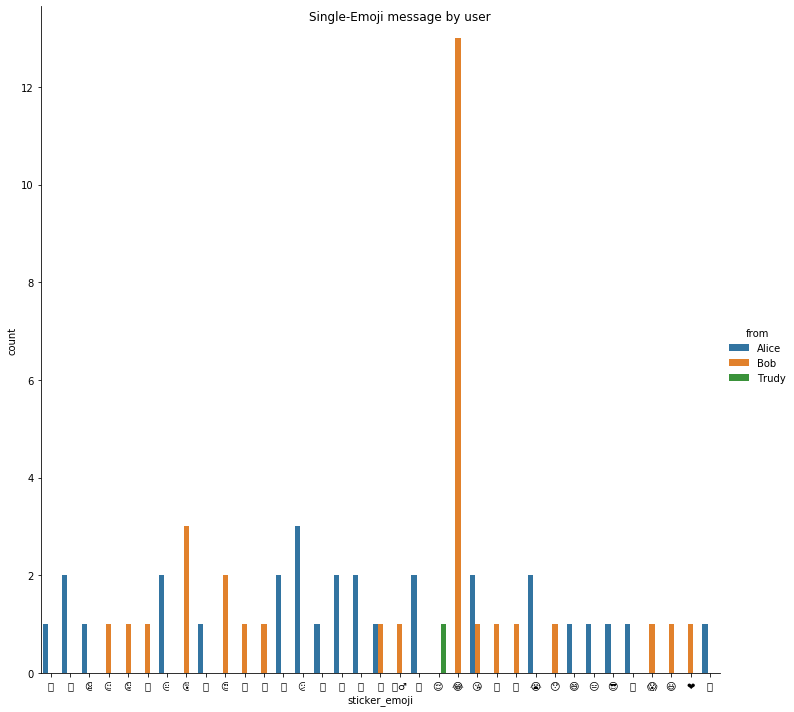

In [31]:
# plotting them all side by side for comparison
g = sns.catplot(x="sticker_emoji", hue="from",
                data=solo_emoji_df, kind="count",
                height=10,orient='h')
g.fig.suptitle('Single-Emoji message by user');

#### Either Bob is a jolly fellow or the other group members are very funny 😂

###### To further research this subject, we're going to have to dive deep into the `text` based messages and analyze the emojis within

## Let's look into those 22k text messages

In [32]:
# we're gonna be working with a text dataframe
text_df= msg_df[['date','from','text']]
text_df['text'].replace('', np.nan, inplace=True) # replace empty strings with NaN
text_df.dropna(subset=['text'], inplace=True) #drop NaN
text_df.sample(5)

,date,from,text
7749,2020-04-07T09:10:45,Alice,Los sacan a la calle o la quedan y los dejan ahí?
14921,2020-05-30T01:28:53,Trudy,En soledad?
20907,2020-07-03T15:04:35,Bob,"me acaba de decir que pida lo que quiera, que ..."
4620,2020-03-20T16:58:20,Alice,asi que tendría 5 ponele
7855,2020-04-07T16:47:32,Alice,FS?


#### Some data cleaning...

In [33]:
# a customized subset from nltk.stopwords('spanish')
sp_stopwords=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las',
              'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como',
              'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta',
              'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta',
              'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos',
              'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos',
              'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras',
              'otra', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 
              'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo',
              'nosotros', 'mi', 'mis', 'tú', 'te', 'tu', 'tus', 'ellas', 'mío',
              'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo',
              'suya', 'suyos', 'suyas', 'esos', 'esas', 'este', 'hay', 'soy', 'es',
              'de','to','the','is','here','a','of','it','we','for','that','this',
              'all','as','are']
stopwords=[unidecode.unidecode(word) for word in sp_stopwords] #normalizing stopwords

In [34]:
# a customized subset from wikipedia
emoj=[":‑)",":)",":-]",":]",":-3",":3",":->",":>","8-)","8)",
      ":-}",":}",":o)",":c)",":^)","=]","=)","= )","=^)",":‑D",
      ":D","8‑D","8D","x‑D","xD","X‑D","XD","=D","=3","B^D",
      ":^D","=^D",":‑(",":(",":‑c",":c",":‑<",":<",":‑[",":[",
      ":-||",">:[",":{",":@",":(",";(",":'‑(",":'(",":'‑)",
      ":')","D‑':","D:<","D:","D8","D;","D=","DX",":‑O",":O",
      ":‑o",":o",":-0","8‑0",">:O",":-*",":*",":×",";‑)",";)",
      "*-)","*)",";‑]",";]",";^)",":‑,",";D",":‑P",":P","X‑P",
      "XP","x‑p","xp",":‑p",":p",":‑Þ",":Þ",":‑þ",":þ",":‑b",
      ":b","d:","=p",">:P",":‑/",":/",":‑.",">:\\", ">:/",":\\",
      "=/","=\\",":L","=L",":S",":‑|",":|",":$","://)","://3",
      ":‑X",":X",":‑#",":#",":‑&",":&","O:‑)","O:)","0:‑3",
      "0:3","0:‑)","0:)","0;^)",">:‑)",":)","}:‑)","}:)","3:‑)",
      "3:)",">;)",">:3",";3","|;‑)","|‑O",":‑J","#‑)","%‑)",
      "%)",":‑###..",":###..","<:‑|","',:-|","',:-l",":E",
      "</3","<\3","<3","\o/","\o\\","/o/","O_O","o‑o","O_o","O.o",
      "o.O","o.o","O.O","o.0","0.o","o_O","o_o","O-O",":-o_0",
      ":-0_o","<(>.<)>","<(>_<)>","(>.<)","(>_<)","{>.<}","{>_<}",
      "<{>.<}>","<{>_<}>","uwu","UwU","¯\_(ツ)_/¯",":-d",":-p",
      ":-)",";-)",":-(",":-/",":0","u_u","U_U","ñ_ñ"]

##### We're also going to be needing a function to process a message

In [35]:
def process_msg(mesg):
    '''
    Input: `mesg` a string containing the message
    Output `(mesg_clean,weird_words)` a pair of lists of words with the processed message
    '''
    mesg_tokens = mesg.split() # tokenize message
    msg_clean = []
    weird_words= []
    
    for word in mesg_tokens:
        plain_word= unidecode.unidecode(word.lower()) # normalize to lower()
        if (plain_word not in stopwords and  # remove stopwords
            plain_word not in string.punctuation):  # remove punctuation
            
            if plain_word not in emoj:
                #check if any weird words remain
                if(any(char in string.punctuation for char in plain_word) or
                   any(char in ['0123456789'] for char in plain_word)):
                    #print("weird word: {}".format(word)) ## for debugging purposes
                    weird_words.append(plain_word)
                    continue
            # else append to output
            msg_clean.append(plain_word)
    return msg_clean,weird_words

#### I'd like to see which words are the most used in the group, so I'm analyzing some N-grams

In [36]:
one_grams=[]
weird_one_grams=[]
non_string_messages=[]
for msg in text_df['text']:
    if isinstance(msg,str):
        msg_1gram,weird_gram = process_msg(msg)
        one_grams.extend(msg_1gram)
        weird_one_grams.extend(weird_gram)
    else:
        non_string_messages.append(msg)

#show an example of the results
one_grams[1],weird_one_grams[1]

('great', '...')

In [37]:
# let's see how many n-grams I got and how many weird words
len(one_grams),len(weird_one_grams)

(71693, 11800)

###### Looks like I've got a lot of weird words that got cought by `weird_one_grams`. I'll have to come back to look into that

#### For now, I just want to plot the ones that got parsed correctly to get an idea on which words are most used by me and my friends

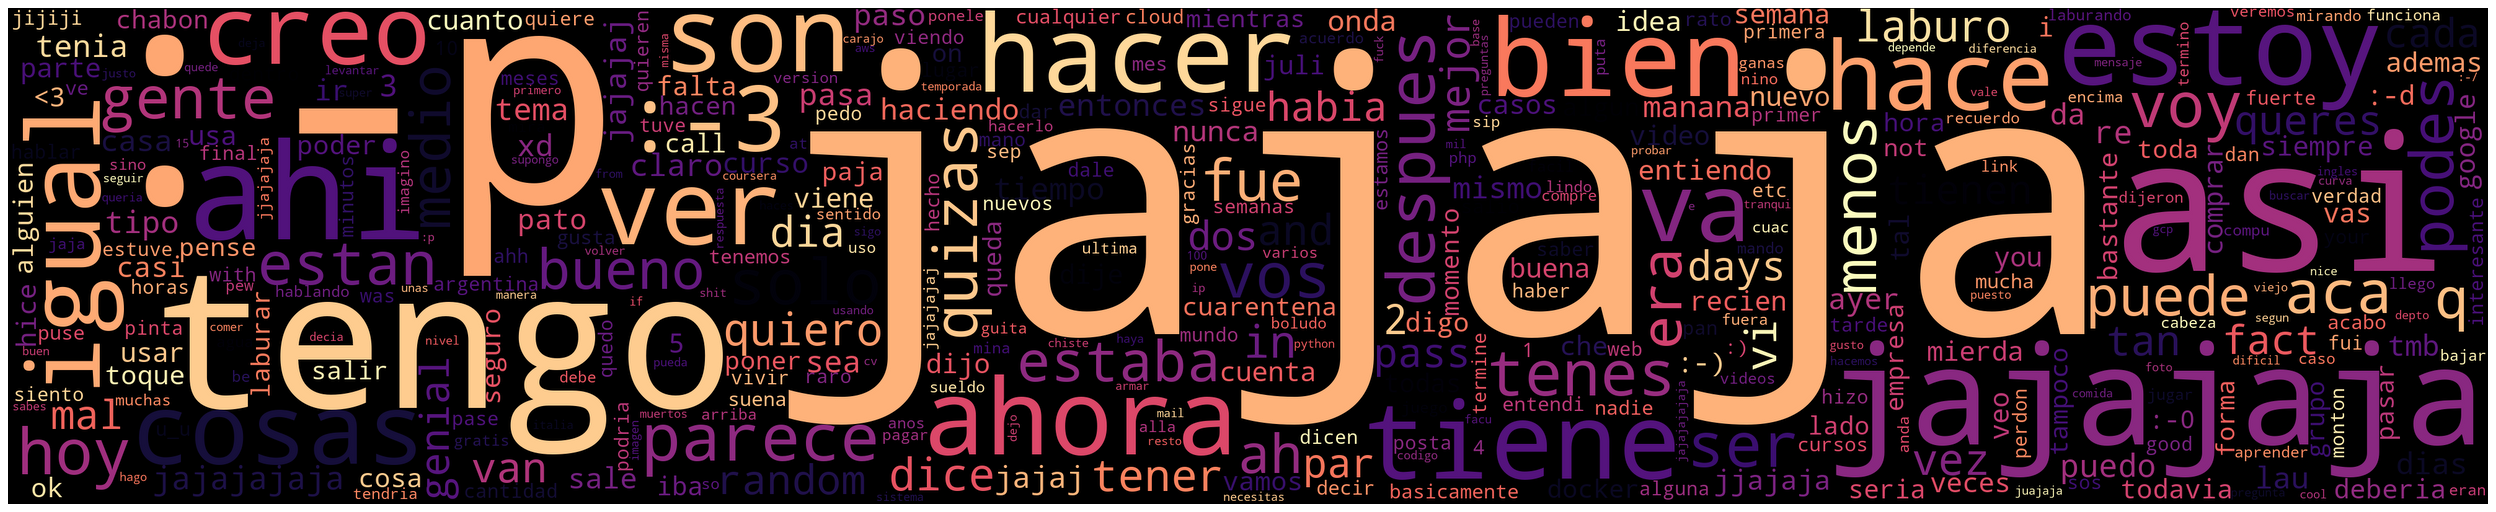

In [41]:
flattened= [word for word in one_grams]
word_freq= defaultdict(int)
for word in flattened:
    word_freq[word]+=1

wc = WordCloud(width = 4000, height = 800,
               min_font_size=10,max_words=400,
              mode='RGBA',colormap='magma',
              min_word_length=2).generate_from_frequencies(word_freq)
plt.figure(figsize=(40, 30), dpi= 80, edgecolor='k')
plt.imshow(wc, interpolation="lanczos")
plt.axis("off")
plt.show()

### It would seem the most common word is `jajaja`, the laughing onomatopoeia for Spanish, followed by the tongue emoji in it's text form `:-p`

##### In the next coding session I'll be extracting emojis from the text, adding them to the previous solo-emoji messages and analyzing their overall use per group member

In [39]:
#TODO:
 # Explore the `text` based messages (22k messages should be the most juicy data)
# Show a word cloud for the most used words
# analyze individual's activity from text-based messages
# calculate distribution for text messages by hour
# calculate distribution for text messages by month
# calculate distribution for text messages by individual
# calculate distribution for most used words
# calculate distribution for most used emoticons
# calculate distribution for urls shared
# calculate correlation between messages sent by group members
# perhaps try to train an AI using those 22k messages as the corpus